In this notebook we test out the various utilities provided by DropletUtils

| Functions      | Use Case | CellRanger Only? |
|----------------|----------|------------------|
| barcodeRanks | Ranking Barcodes |  No |
| defaultDrops | Removing junk cells using CR method | no |
| emptyDrops | Removing junk cells | No |
| swappedDrops | Cleaning overllaping CB+UMI over samples | No |
| makeCountMatrix | None for most users | No |
| downsampleMatrix | Downsampling across Cells | No |
| downsampleReads | Downsampling reads | Requires MoleculeInfo |
| encodeSequences | None for most users | No |
| read10xCounts | Reading/Writing a 10x count matrix | No |
| write10xCounts | Reading/Writing a 10x count matrix | No |
| get10xMolInfoStats | ??? | Requires MoleculeInfo |
| read10xMolInfo | Molecule information QC | Requires MoleculeInfo |

After playing with the library I can see some useful/novel modules:

 1. Barcode Ranking Plots
 1. DefaultDrops
 1. EmptyDrops
 
These should take in one of either a directory/{barcodes.tsv,genes.tsv,matrix.mtx} or an h5ad file or a simple tsv.

 

In [3]:
library(DropletUtils)

### Testing Barcode Rankings

In [114]:
#br.out <- barcodeRanks(counts(sce))
br.out <- barcodeRanks(my.counts)

In [115]:
str(br.out)

List of 5
 $ rank      : num [1:11100] 10152 7956 5525 5525 10528 ...
 $ total     : num [1:11100] 2 9 20 20 1 25 7 35 128 6 ...
 $ fitted    : num [1:11100] NA NA NA NA NA NA NA NA NA NA ...
 $ knee      : num 721
 $ inflection: num 339


In [116]:
br.out <- barcodeRanks(counts(sce))

In [117]:
str(br.out)

List of 5
 $ rank      : Named num [1:737280] 313274 649178 33604 649178 469705 ...
  ..- attr(*, "names")= chr [1:737280] "AACTGGTGTGCAACTT" "GTTAAGCCATGTCCTC" "TCAACGATCACGAAGG" "AAAGATGAGAAGGTTT" ...
 $ total     : Named num [1:737280] 2 0 512 0 1 1 564 0 539 0 ...
  ..- attr(*, "names")= chr [1:737280] "TAGACCAAGATGGGTC" "AACTGGTGTGCAACTT" "GTTAAGCCATGTCCTC" "TCAACGATCACGAAGG" ...
 $ fitted    : num [1:737280] NA NA 541 NA NA ...
 $ knee      : Named num 25428
  ..- attr(*, "names")= chr "TTCTACAAGGAGTACC"
 $ inflection: Named num 135
  ..- attr(*, "names")= chr "TGACTAGCAGTTCATG"


Warning message in xy.coords(x, y, xlabel, ylabel, log):
“176205 y values <= 0 omitted from logarithmic plot”

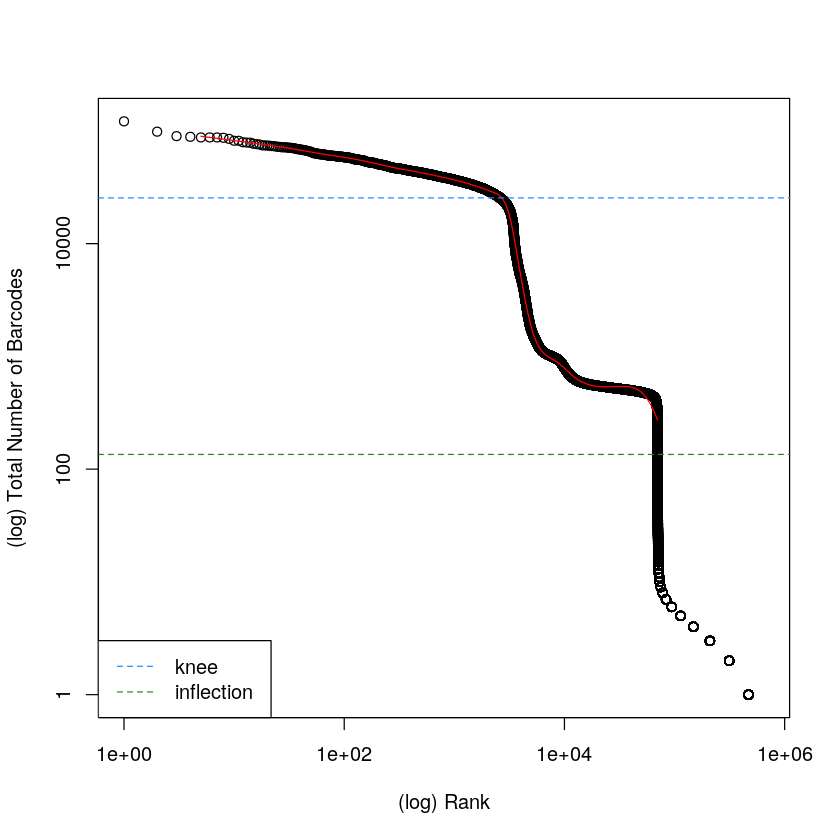

In [118]:
br.out <- barcodeRanks(counts(sce))

# Making a plot.
plot(br.out$rank, br.out$total, log="xy", xlab="(log) Rank", ylab="(log) Total Number of Barcodes")
o <- order(br.out$rank)
lines(br.out$rank[o], br.out$fitted[o], col="red")

abline(h=br.out$knee, col="dodgerblue", lty=2)
abline(h=br.out$inflection, col="forestgreen", lty=2)
legend("bottomleft", lty=2, col=c("dodgerblue", "forestgreen"), 
    legend=c("knee", "inflection"))

In [120]:
head(br.out)

### EmptyDrops

EmptyDrops uses barcodeRanks, so perhaps we can get a knee plot as before using this? Nope. The knee value is used *with* the results of the testEmptyDrops, but surprisingly the knee is not suggestive of the final barcode numbers.

In [17]:
sce <- read10xCounts("outputs/V2/")

In [18]:
set.seed(100)

In [20]:
e.out <- emptyDrops(counts(sce))

In [127]:
nrow(e.out) == length(colnames(sce))
#cbind(colnames(sce), e.out)

[1] TRUE

Droplets with signficiant deviations from the ambient profile are detected at a specified FDR threshold (<1%). 

In [74]:
e.out$is.cell <- e.out$FDR <= 0.01
sum(e.out$is.cell, na.rm=T)

[1] 4358

In [75]:
head(e.out)

DataFrame with 6 rows and 6 columns
      Total           LogProb            PValue   Limited       FDR   is.cell
  <integer>         <numeric>         <numeric> <logical> <numeric> <logical>
1         2                NA                NA        NA        NA        NA
2         0                NA                NA        NA        NA        NA
3       512 -1075.67232724452 0.853314668533147     FALSE         1     FALSE
4         0                NA                NA        NA        NA        NA
5         1                NA                NA        NA        NA        NA
6         1                NA                NA        NA        NA        NA

In [23]:
table(Limited=e.out$Limited, Significant=is.cell)

       Significant
Limited FALSE  TRUE
  FALSE 65826    38
  TRUE      0  4320

We want to keep cells that are significant and limitied (where a lower p-value could be obtained with an increasing number of iterations)

In [76]:
df = na.omit(e.out)

In [81]:
df

DataFrame with 70184 rows and 6 columns
          Total           LogProb            PValue   Limited
      <integer>         <numeric>         <numeric> <logical>
1           512 -1075.67232724452 0.853314668533147     FALSE
2           564 -1187.18982933511  0.57024297570243     FALSE
3           539 -1106.50863181964 0.897510248975102     FALSE
4           458 -960.269603504992 0.973902609739026     FALSE
5           517 -1037.42756832511 0.987601239876012     FALSE
...         ...               ...               ...       ...
70180       542 -1071.61604172506 0.988501149885011     FALSE
70181     20374 -12975.0943923459 9.99900009999e-05      TRUE
70182       962 -1582.54747336245 0.995300469953005     FALSE
70183       981 -1614.27238877572 0.991600839916008     FALSE
70184     36432 -19107.1707734292 9.99900009999e-05      TRUE
                      FDR   is.cell
                <numeric> <logical>
1                       1     FALSE
2                       1     FALSE
3         

In [80]:
df[df$Limited & df$FDR <= 0.01,]

DataFrame with 4320 rows and 6 columns
         Total           LogProb            PValue   Limited
     <integer>         <numeric>         <numeric> <logical>
1         6465 -8626.13068475245 9.99900009999e-05      TRUE
2        31726 -17305.6739537149 9.99900009999e-05      TRUE
3         4659 -7029.15547724528 9.99900009999e-05      TRUE
4         6521 -8670.37387646634 9.99900009999e-05      TRUE
5        35200 -19462.4136028636 9.99900009999e-05      TRUE
...        ...               ...               ...       ...
4316     33679 -17707.7714116705 9.99900009999e-05      TRUE
4317     47562  -21144.991828915 9.99900009999e-05      TRUE
4318     41428 -21800.5580195018 9.99900009999e-05      TRUE
4319     20374 -12975.0943923459 9.99900009999e-05      TRUE
4320     36432 -19107.1707734292 9.99900009999e-05      TRUE
                     FDR   is.cell
               <numeric> <logical>
1    0.00162446718291134      TRUE
2                      0      TRUE
3    0.00162446718291134    

In [66]:
dim(df)

[1] 70184     5

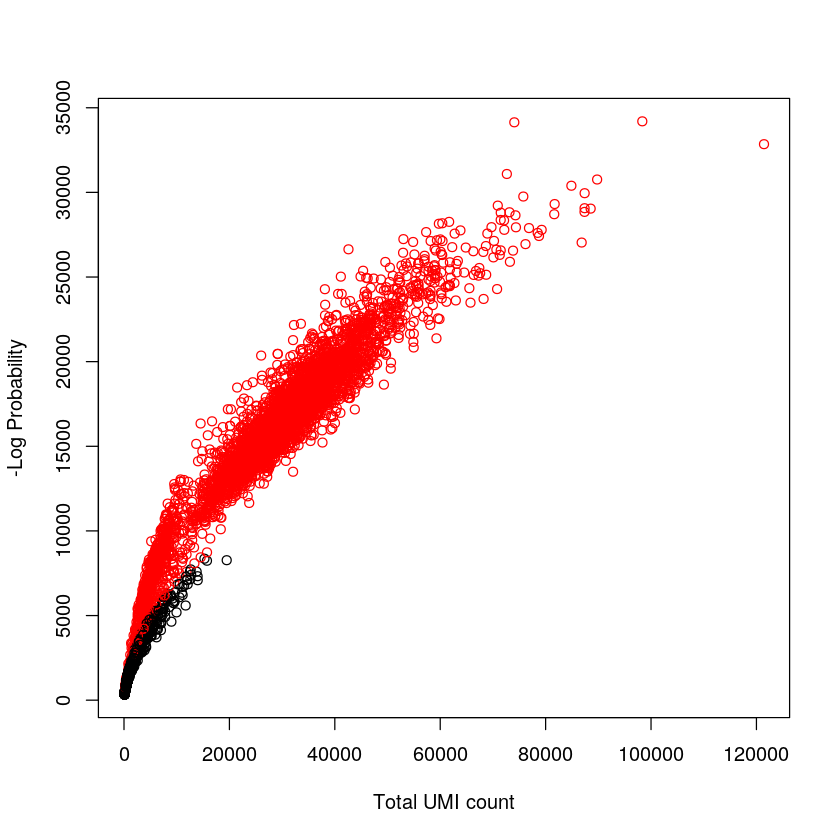

In [24]:
plot(e.out$Total, -e.out$LogProb, col=ifelse(is.cell, "red", "black"),
    xlab="Total UMI count", ylab="-Log Probability")

### DefaultDrops (the CR method of EmtpyDrops)

In [85]:
sce <- read10xCounts("outputs/V2/", col.names=T)

In [86]:
counts(sce)[1:10,1:10]

   [[ suppressing 10 column names ‘AAACCTGAGAAACCAT’, ‘AAACCTGAGAAACCGC’, ‘AAACCTGAGAAACCTA’ ... ]]


10 x 10 sparse Matrix of class "dgCMatrix"
                                   
ENSG00000223972 . . . . . . . . . .
ENSG00000227232 . . . . . . . . . .
ENSG00000278267 . . . . . . . . . .
ENSG00000243485 . . . . . . . . . .
ENSG00000284332 . . . . . . . . . .
ENSG00000237613 . . . . . . . . . .
ENSG00000268020 . . . . . . . . . .
ENSG00000240361 . . . . . . . . . .
ENSG00000186092 . . . . . . . . . .
ENSG00000238009 . . . . . . . . . .

In [87]:
d.out <- defaultDrops(counts(sce))

In [98]:
head(d.out[d.out==T])

AAACCTGCACGCTTTC AAACCTGGTGAAATCA AAACCTGGTTACAGAA AAACCTGGTTCCATGA 
            TRUE             TRUE             TRUE             TRUE 
AAACCTGTCACAGGCC AAACCTGTCCCATTTA 
            TRUE             TRUE

In [89]:
message("Cells to keep: ", sum(d.out))

Cells to keep: 3717


This is very close to the 3709 generated by CellRanger

In [92]:
sce.filtered <- sce[,d.out]

In [102]:
write10xCounts("outputs//V2_on_DropletUtils", counts(sce.filtered), overwrite=T)

# Methods for Wrappers

### Galaxy Helpers

We need a method that takes a barcodes, matrix.mtx, and genes.tsv and places them into a directory that read10X in directory mode can read

### R Helpers

In [197]:
writeTSV <- function(fileout, obj){
    write.table(as.matrix(obj), file=fileout, col.names=NA, sep='\t', quote=FALSE)
}

writeOut <- function(counts, fileout, typeout){
    if (typeout == "tsv"){
        writeTSV(fileout, counts)
    }
    else if (typeout == "h5ad"){
        write10xCounts(fileout, counts, type="HDF5", overwrite=TRUE)
    }
    else if (typeout == "directory"){
        write10xCounts(paste(fileout, "sets", sep="."), counts, type="sparse", overwrite=TRUE)
    }
}


read10xFiles <- function(filein, typein){
    sce <- NULL
    if (typein == "tsv"){
        dat <- read.table(filein, header = TRUE,  sep='\t', stringsAsFactors=FALSE, quote="")
        sce <- SingleCellExperiment(assays = list(counts = as.matrix(dat)))
    }
    else if (typein == "h5ad"){
        sce <- read10xCounts(filein, col.names=T, type="HDF5")   # use barcodes.tsv as column names
    }
    else if (typein == "directory"){
        sce <- read10xCounts(filein, col.names=T, type="sparse")
    }
    return(sce)
}

## doEmptyDrops

In [198]:
doEmptyDrops <- function(files, in.type="directory", out.type="h5ad", fdr_threshold = 0.01, seed=100){
    set.seed(seed)
    sce <- read10xFiles(files$read_directory, in.type)
    
    e.out <- emptyDrops(counts(sce))
    
    bar.names <- colnames(sce)
    if (length(bar.names) != nrow(e.out)){    
        stop("Length of barcodes and output metrics don't match.")
    }
    e.out <- cbind(bar.names, e.out)
    e.out$is.Cell <- e.out$FDR <= fdr_threshold
    e.out$is.CellAndLimited <- e.out$is.Cell & e.out$Limited
    
    # Write to table
    writeTSV(e.out, files$table)
    
    # Print to log
    print(table(Limited=e.out$Limited, Significant=e.out$is.Cell))
    
    # Write to Plot
    png(files$plot)
    plot(e.out$Total, -e.out$LogProb, col=ifelse(e.out$is.Cell, "red", "black"),
    xlab="Total UMI count", ylab="-Log Probability")
    dev.off()
    
    # Filtered
    called <- e.out$is.CellAndLimited
    called[is.na(called)] <- FALSE    # replace NA's with FALSE
    sce.filtered <- sce[,called]
    
    # Write all to directory or a tabular count matrix for further downstream
    writeOut(counts(sce.filtered), files$writematrices, out.type)
}

In [199]:
# Test

tmp = list()
tmp$read_directory = "outputs/V2"
tmp$writematrices = "test_scripts/outfile"
tmp$table = "test_scripts/Metrics.tsv"
tmp$plot = "test_scripts/Plot.png"

doEmptyDrops(tmp)

ERROR: Error in (function (classes, fdef, mtable) : unable to find an inherited method for function ‘pcompare’ for signature ‘"DataFrame", "character"’


## doDefaultDrops

In [ ]:
dparams=list()
dparams$expected=3000
dparams$upper.quant = 0.99
dparams$lower.prop=0.1

doDefaultDrops <- function(files, dparams, in.type="directory", out.type="h5ad", seed = 100){
    set.seed(seed)
    sce <- read10xFiles(files$read_directory, in.type)
    
    called <- do.call(defaultDrops, c(counts(sce), dparams))
    print(table(called))
        
    # Filtered
    sce.filtered <- sce[,called]
    
    # Write all to directory or a tabular count matrix for further downstream
    writeOut(counts(sce.filtered), files$writematrices, out.type)
}

In [193]:
# Test
tmp = list()
tmp$read_directory = "outputs/V2"
tmp$writematrices = "test_scripts/outfile"

params=list()
params$expected=3000
params$upper.quant = 0.99
params$lower.prop=0.1

doDefaultDrops(tmp, params, "h5ad")

## Barcode Rankings

In [209]:
bparams = list()
bparams$lower=100
bparams$fit.bounds=NULL
bparams$df=20

files = list()
files$in.path = "outputs/V2"
files$plot = "test_scripts/Plot.png"

doBarcodeRankings <- function(files, bparams, in.type="directory", seed = 100){
    set.seed(seed)
    sce <- read10xFiles(files$in.path, in.type)

    br.out <- barcodeRanks(counts(sce))
    
    png(files$plot)
    plot(br.out$rank, br.out$total, log="xy", xlab="(log) Rank", ylab="(log) Total Number of Barcodes")
    o <- order(br.out$rank)
    lines(br.out$rank[o], br.out$fitted[o], col="red")

    abline(h=br.out$knee, col="dodgerblue", lty=2)
    abline(h=br.out$inflection, col="forestgreen", lty=2)
    legend("bottomleft", lty=2, col=c("dodgerblue", "forestgreen"), legend=c("knee", "inflection"))
    dev.off()
    
    print(paste("knee =", br.out$knee, ", inflection = ", br.out$inflection))
}

In [210]:
doBarcodeRankings(files, bparams)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“176205 y values <= 0 omitted from logarithmic plot”

[1] "knee = 25428 , inflection =  135"


# Testing

In [185]:
files$writematrices = "test_scripts/outfile"
writeOut(counts(sce.filtered), files$writematrices, "directory")

In [167]:
#output_matrix
files$write_directory = "test_scripts/"
files$write_matrix = "test_scripts/counts.tsv"
out.type = 
writeOut(counts(sce.filtered), files$write_directory, files$write_matrix, out.type)

In [165]:
as.matrix(counts(sce.filtered)[1:10,1:10])

,AAACCTGCAAGCCTAT,AAACCTGCACGCTTTC,AAACCTGCACGGTAGA,AAACCTGCATAGACTC,AAACCTGGTGAAATCA,AAACCTGGTTACAGAA,AAACCTGTCACAGGCC,AAACCTGTCCCATTTA,AAACCTGTCCGATATG,AAACCTGTCGCAGGCT
ENSG00000223972,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,0,0,0,0,0,0,0,0,0,0
ENSG00000278267,0,0,0,0,0,0,0,0,0,0
ENSG00000243485,0,0,0,0,0,0,0,0,0,0
ENSG00000284332,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0,0,0
ENSG00000240361,0,0,0,0,0,0,0,0,0,0
ENSG00000186092,0,0,0,0,0,0,0,0,0,0
ENSG00000238009,0,0,0,0,0,0,0,0,0,0


In [153]:
# Filtered
called <- e.out$is.CellAndLimited
called[is.na(called)] <- FALSE
length(called)
sum(called)

sce.filtered <- sce[,called]
dim(sce.filtered)

[1] 737280

[1] 4320

[1] 58884  4320

In [ ]:
out.type,